# DRN demo using solar flares data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools as it
import pyvis
from pyvis.network import Network
import toolz as tz
import colorcet as cc

## Intro to The Problem

## Dataset Overview
### Solar Flare dataset
#### About 
A solar flare is a short-lived sudden increase in the intensity of radiation emitted in the neighborhood of sunspots [1]. Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period.
#### Source information
UCI Machine Learning Repository <br>
Number of Instances: 1066
#### Attribute Information
- `klass`: Code for class (modified Zurich class) (A, B, C, D, E, F, H)
- `size`: Code for largest spot size (X, R, S, A, H, K)
- `dist`: Code for spot distribution (X, O, I, C)
- `act`: Activity                                (1 = reduced, 2 = unchanged)
- `evo`: Evolution                               (1 = decay, 2 = no growth, 3 = growth)
- `prev`: Previous 24 hour flare activity code    (1 = nothing as big as an M1,2 = one M1,3 = more activity than one M1)
- `complex`: Historically-complex                    (1 = Yes, 2 = No)
- `hist_complex`: Did region become historically complex on this pass across the sun's disk (1 = yes, 2 = no) 
- `area`: Area                                    (1 = small, 2 = large)
- `c_class`: small with few noticeable consequences on Earth
- `m_class`: medium-sized; cause brief radio blackouts that affect Earth's polar regions
- `x_class`: big; major events that can trigger planet-wide radio blackouts and long-lasting radiation storms

#### References
- [1] National Centers for Environmental Information. Solar flares. https://www.ngdc.noaa.gov/stp/solar/solarflares.html
- [2] SpaceWeather.com. The Classification of X-ray Solar Flares. https://www.spaceweather.com/glossary/flareclasses.html

## Dataset Exploration

load the dataset

In [2]:
x = pd.read_csv('solar_flare.csv.gz')
x.head()

,klass,size,dist,act,evo,prev,complex,hist_complex,area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,0,0,0
2,C,S,O,1,3,1,1,2,1,0,0,0
3,H,R,X,1,2,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,0,0,0


construct the contingency table for class [B, C, D, E, F, H] and size [A, H, K, R, S, X]

In [3]:
x.groupby(['klass','size']).count()['dist'].unstack().fillna(0).astype(int)

size,A,H,K,R,S,X
klass,,,,,,
B,0,0,0,0,2,145
C,24,3,1,93,90,0
D,93,8,14,59,65,0
E,46,6,18,3,22,0
F,20,3,12,1,7,0
H,33,7,1,62,228,0


explore all the possible responses for each attribute

In [4]:
x.apply(lambda i:i.unique())

klass                 [H, D, C, B, E, F]
size                  [A, R, S, X, K, H]
dist                        [X, O, I, C]
act                               [1, 2]
evo                            [3, 2, 1]
prev                           [1, 3, 2]
complex                           [1, 2]
hist_complex                      [1, 2]
area                              [1, 2]
c_class         [0, 1, 5, 2, 3, 8, 4, 6]
m_class               [0, 1, 4, 3, 2, 5]
x_class                        [0, 1, 2]
dtype: object

append the attribute to the response as `tags` to match the generalized row-wise format

| Unit      | Tags | 
| :---        |    ----:   |
| $u_1$      | $t_{k_{11}}$,$t_{k_{12}}$,...,$t_{k_{n_1}}$| 
| ...   | ...        | 
| $u_m$   | $t_{k_{m1}}$,$t_{k_{m2}}$,...,$t_{k_{n_m}}$       | 


In [5]:
df = x.apply(lambda i:i.name+'_'+i.astype(str))
df.head()

,klass,size,dist,act,evo,prev,complex,hist_complex,area,c_class,m_class,x_class
0,klass_H,size_A,dist_X,act_1,evo_3,prev_1,complex_1,hist_complex_1,area_1,c_class_0,m_class_0,x_class_0
1,klass_D,size_R,dist_O,act_1,evo_3,prev_1,complex_1,hist_complex_2,area_1,c_class_0,m_class_0,x_class_0
2,klass_C,size_S,dist_O,act_1,evo_3,prev_1,complex_1,hist_complex_2,area_1,c_class_0,m_class_0,x_class_0
3,klass_H,size_R,dist_X,act_1,evo_2,prev_1,complex_1,hist_complex_1,area_1,c_class_0,m_class_0,x_class_0
4,klass_H,size_S,dist_X,act_1,evo_1,prev_1,complex_1,hist_complex_2,area_1,c_class_0,m_class_0,x_class_0


## Data Reduction Network Construction
- Step 1: Graph Construction
    1. form a clique from all the tags of a given row
    2. combine the edge with the same endpoints and increment `cnt` by 1
- Step 2: Simplify the Graph
    1. apply Prim's algorithm (Minimum Spanning Tree algorithm) to prune the number of edges to the minimal most likely set, based on `cnt`


In [6]:
class CounterDict(dict):
    def update(self,d):
        for k,v in d.items():
            if k in self:
                self[k]+=v
            else:
                self[k]=v

class CounterGraph(nx.Graph):
    '''
    CounterGraph extends from networkx Graph object
    
    `edge_attr_dict_factory`: override the factory function to be used to create the graph attribute dict
                              which holds attribute values keyed by attribute name
    here add the edge between every two tag in the same row and the edge has attribute 'cnt'
    '''
    edge_attr_dict_factory = CounterDict

In [7]:
# initialize the graph
g = CounterGraph()

# add the edge between every two tag in the same row and increment the 'cnt' of edge by 1
for row in df.iterrows():
    g.add_edges_from(it.combinations(row[1],2),cnt=1)


In [8]:
g['klass_F']['size_K']['cnt']

12

Simply the graph by Minimum Spanning Tree Algorithm

In [9]:
t = nx.maximum_spanning_tree(g, weight='cnt')

## display the tree

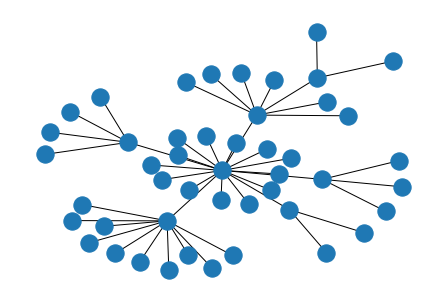

In [10]:
nx.draw_kamada_kawai(t)

In [11]:
nt = Network(notebook=True,width='100%')

In [12]:
nt.from_nx(t)

In [13]:
# nodes proportional to counts 
for i in df.columns:
    for k,v in df[i].value_counts().items():
        nt.node_map[k]['size'] = v/20
        nt.node_map[k]['title'] = k # add hover to node

In [14]:
node_colors = dict(zip(df.columns, cc.b_glasbey_category10))
# different node colors for each column
tz.valmap(lambda i:i.update({'color':node_colors[i['id'].rsplit('_',1)[0]]}),nt.node_map);

In [15]:
# update edges by weight
edge_lookup = {(i['from'],i['to']) :n for n,i in enumerate(nt.edges)}

for i,j,d in t.edges(data=True):
    nt.edges[edge_lookup[(i,j)]]['width'] = g[i][j]['cnt']/100

In [16]:
nt.show('nx.html')

## Interpreting MST Features

#### Observation 1
- There are thick edges between `x_class_0`, `c_class_0`, `m_class_0`, there might be statistically significance between them

In [17]:
x.groupby([ 'x_class','c_class', 'm_class',]).count()['act'].to_frame()

act
x_class c_class m_class     
0       0       0        865
                1         15
                2          1
                3          1
        1       0        104
                1          5
        2       0         27
                1          4
                2          2
        3       0         18
                1          2
        4       0          7
                1          1
                4          1
        5       0          3
                1          1
        6       0          3
        8       0          1
1       0       1          1
                5          1
        1       0          2
2       1       3          1

explore relationship between `klass` and `area`

In [18]:
x.groupby(['klass', 'area']).count()['size'].unstack().fillna(0).astype(int)

area,1,2
klass,,
B,147,0
C,211,0
D,238,1
E,80,15
F,32,11
H,331,0
